# Predicción de Consumo Energético usando Machine Learning

## Modelos de regresión basadps en machine learning para predecir consumo energético basado en las variables 'ID_Cliente', 'Sector', 'Consumo_kWh_Mensual', 'Estrato', 'Ciudad', 'Area_m2', 'Factura_Mensual_COP', 'Puede_Pagar_Solar', las cuales fueron previamente preprocesadas a través de limpieza de outliers en Excel usando el método IQR

*Resumen general*
Este notebook entrena y compara modelos de regresión para predecir el consumo energético mensual (kWh) a partir de variables como sector, estrato, ciudad, área y capacidad de pago.

Estructura del código
1. Carga y exploración de datos
Carga datos desde un Excel (Paneles_solares_con_outliers.xlsx)
460 registros con 9 columnas
Analiza distribuciones, correlaciones y valores nulos

2. Preprocesamiento
Elimina columnas no predictoras (ID_Cliente, Validar, Factura_Mensual_COP)
Codifica variables categóricas (Sector, Ciudad, Puede_Pagar_Solar)
Imputa valores nulos
Divide los datos: 70% entrenamiento, 30% prueba
Estandariza las características numéricas

3. Entrenamiento de modelos
Evalúa 7 modelos de regresión:
Regresión Lineal
Ridge
Lasso
ElasticNet
Árbol de Decisión
Random Forest
Gradient Boosting
Cada modelo se optimiza con GridSearchCV y se evalúa con:
R² Score
RMSE (Error Cuadrático Medio)
MAE (Error Absoluto Medio)
Validación cruzada (5 folds)

4. Comparación y selección
Compara todos los modelos
Selecciona el mejor según R² de test (validación con 30% de datos de prueba)
Resultado: Random Forest (R² = 0.8530) , este fue el mejor resultado.

5. Visualizaciones
Gráficos de comparación de métricas
Predicciones vs valores reales
Análisis de residuos
Dashboard con múltiples visualizaciones

6. Generación de reportes
Reporte Excel con 4 hojas:
Resumen Ejecutivo
Comparación de Modelos
Predicciones y Errores
Variables Predictoras

7. Guardado del modelo
Guarda el modelo entrenado (.pkl)
Guarda el escalador y otros objetos necesarios
Genera metadatos en JSON

8. Sistema de predicción
Función predecir_desde_excel() para hacer predicciones con datos nuevos
Crea plantillas Excel de ejemplo
Genera reportes de predicciones
Resultado principal
El mejor modelo es Random Forest con:
R² Score: 0.8530 (explica el 85.3% de la varianza)
RMSE: 968.78 kWh

Conclusión: Variable más importante: Area_m2 (97.5% de importancia)
El código está listo para predecir el consumo energético con nuevos datos, y en este caso la predicción se hará con base en las variables seleccionadas, donde el 97.5% es el peso de la variable más importante.

*A continuación los pasos para obtener el resultado*

0. Cómo cargar las librerias necesarias para el programa

In [2]:
# Librerías necesarias
# Librería pandas para manipulación de datos y análisis
import pandas as pd #Pandas es una biblioteca de Python que proporciona estructuras de datos flexibles y eficientes para manipular y analizar datos.
import numpy as np #Numpy es una biblioteca de Python que proporciona estructuras de datos eficientes para manipular y analizar datos numéricos.
import matplotlib.pyplot as plt #Matplotlib es una biblioteca de Python que proporciona una interfaz de usuario para crear gráficos y visualizaciones de datos. 
import seaborn as sns #Seaborn es una biblioteca de Python que proporciona una interfaz de usuario para crear gráficos y visualizaciones de datos.

# Librería sklearn para el aprendizaje automático
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  #sklearn es una biblioteca de Python que proporciona una serie de códigos para el aprendizaje automático   
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

# Librería openpyxl para la lectura de archivos Excel
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side

# Librería para evitar advertencias
import warnings
warnings.filterwarnings('ignore')
warnings.warn("Esta advertencia nunca se mostrará.")
print("El script continúa...")

# Librería para el estilo de los graficos que se usaran con seaborn
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

El script continúa...


## 1. Carga de Datos

In [3]:
# Cargar datos. Advertencia
df = pd.read_excel('Paneles_solares_con_outliers.xlsx', sheet_name='Datos Limpios') # Cargar datos con la libreria pandas (pd) con el comando read_excel que elee el archivo un la hoja de calculo de excel
print(f"Forma del dataset: {df.shape}") # Imprime el numero de filas y columnas del dataframe
print(f"\nColumnas: {df.columns.tolist()}") # Imprime el nombre de las columnas del dataframe
df.head() # Imprime las primeras 5 filas del dataframe, si deseas ver mas filas puedes cambiar (incluir) el numero en el parentesis, o incluir el comando df.tail() para ver las ultimas filas

Forma del dataset: (460, 9)

Columnas: ['ID_Cliente', 'Sector', 'Consumo_kWh_Mensual', 'Estrato', 'Ciudad', 'Area_m2', 'Factura_Mensual_COP', 'Puede_Pagar_Solar', 'Validar']


,ID_Cliente,Sector,Consumo_kWh_Mensual,Estrato,Ciudad,Area_m2,Factura_Mensual_COP,Puede_Pagar_Solar,Validar
0,RES-0001,Residencial,209.802849,4,Planeta Rica,77.234714,130077.766492,No,VALIDO
1,RES-0002,Residencial,108.131614,1,Sahagún,122.833169,67041.600932,No,VALIDO
2,RES-0003,Residencial,196.742478,4,Planeta Rica,100.210306,121980.336070,No,VALIDO
3,RES-0004,Residencial,145.147312,2,Lorica,69.496604,89991.333414,No,VALIDO
4,RES-0005,Residencial,181.333310,3,Lorica,71.444142,112426.651950,No,VALIDO


## 2. Análisis Exploratorio de Datos

In [4]:
# Información general
print("=== INFORMACIÓN GENERAL ===") # Imprime el titulo de la sección
print(df.info()) # Imprime la información general del dataframe
# Dtype object: significa que el tipo de dato es un objeto, es decir, una cadena de caracteres.
# Dtype int64: significa que el tipo de dato es un entero de 64 bits.
# Dtype float64: significa que el tipo de dato es un flotante de 64 bits. Un flotante es un numero decimal.

=== INFORMACIÓN GENERAL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID_Cliente           460 non-null    object 
 1   Sector               460 non-null    object 
 2   Consumo_kWh_Mensual  456 non-null    float64
 3   Estrato              460 non-null    int64  
 4   Ciudad               460 non-null    object 
 5   Area_m2              460 non-null    float64
 6   Factura_Mensual_COP  456 non-null    float64
 7   Puede_Pagar_Solar    460 non-null    object 
 8   Validar              460 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 32.5+ KB
None


In [5]:
print("\n=== VALORES NULOS ===") # Imprime el titulo de la sección  
print(df.isnull().sum()) # Imprime el numero de valores nulos en cada columna  
# Si el valor es 0, significa que no hay valores nulos en esa columna.
# Si el valor es mayor a 0, significa que hay valores nulos en esa columna.


=== VALORES NULOS ===
ID_Cliente             0
Sector                 0
Consumo_kWh_Mensual    4
Estrato                0
Ciudad                 0
Area_m2                0
Factura_Mensual_COP    4
Puede_Pagar_Solar      0
Validar                0
dtype: int64


`describe()` en pandas genera estadísticas descriptivas de las columnas numéricas de un DataFrame. Muestra un resumen con:

- count: cantidad de valores no nulos
- mean: promedio
- std: desviación estándar
- min: valor mínimo
- 25%: primer cuartil (Q1)
- 50%: mediana (Q2)
- 75%: tercer cuartil (Q3)
- max: valor máximo

En tu notebook (línea 351), `df.describe()` muestra estas estadísticas para las columnas numéricas como `Consumo_kWh_Mensual`, `Estrato`, `Area_m2` y `Factura_Mensual_COP`.

Ejemplo de salida:
```
       Consumo_kWh_Mensual     Estrato      Area_m2  Factura_Mensual_COP
count           456.000000  460.000000   460.000000         4.560000e+02
mean           2135.094265    4.167391   546.515401         1.323758e+06
std            2424.882968    1.293617   530.660066         1.503427e+06
min              51.248594    1.000000    39.553701         3.177413e+04
25%             222.775573    3.000000    97.470426         1.381209e+05
50%             894.231772    4.000000   299.151220         5.544237e+05
75%            4303.494545    5.000000  1077.565632         2.668167e+06
max            9814.000000    6.000000  1850.420779         6.084680e+06
```

Útil para:
- Entender la distribución de los datos
- Detectar valores atípicos
- Ver el rango y la dispersión de las variables
- Realizar un análisis exploratorio inicial


In [6]:
# Generemos las estadísticas descriptivas 
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===") # Imprime el titulo de la sección  
print(df.describe()) # Imprime las estadísticas descriptivas del dataframe  


=== ESTADÍSTICAS DESCRIPTIVAS ===
       Consumo_kWh_Mensual     Estrato      Area_m2  Factura_Mensual_COP
count           456.000000  460.000000   460.000000         4.560000e+02
mean           2135.094265    4.167391   546.515401         1.323758e+06
std            2424.882968    1.293617   530.660066         1.503427e+06
min              51.248594    1.000000    39.553701         3.177413e+04
25%             222.775573    3.000000    97.470426         1.381209e+05
50%             894.231772    4.000000   299.151220         5.544237e+05
75%            4303.494545    5.000000  1077.565632         2.668167e+06
max            9814.000000    6.000000  1850.420779         6.084680e+06


In [7]:
# Identificar variables categóricas y numéricas
categorical_vars = df.select_dtypes(include=['object']).columns.tolist() #selecciona variables categóricas
numerical_vars = df.select_dtypes(include=[np.number]).columns.tolist() #selecciona variables numéricas

print("Variables categóricas:", categorical_vars)
print("Variables numéricas:", numerical_vars)

# Análisis de variables categóricas
print("\n=== ANÁLISIS VARIABLES CATEGÓRICAS ===")
for var in categorical_vars:
    print(f"\n{var}:")
    print(df[var].value_counts())

Variables categóricas: ['ID_Cliente', 'Sector', 'Ciudad', 'Puede_Pagar_Solar', 'Validar']
Variables numéricas: ['Consumo_kWh_Mensual', 'Estrato', 'Area_m2', 'Factura_Mensual_COP']

=== ANÁLISIS VARIABLES CATEGÓRICAS ===

ID_Cliente:
ID_Cliente
IND-0008    2
IND-0145    2
RES-0051    2
COM-0068    2
RES-0085    2
           ..
RES-0150    1
RES-0149    1
RES-0148    1
RES-0147    1
IND-0150    1
Name: count, Length: 450, dtype: int64

Sector:
Sector
Industrial     155
Residencial    154
Comercial      151
Name: count, dtype: int64

Ciudad:
Ciudad
Cereté          102
Sahagún          96
Montería         94
Planeta Rica     88
Lorica           80
Name: count, dtype: int64

Puede_Pagar_Solar:
Puede_Pagar_Solar
Sí    319
No    141
Name: count, dtype: int64

Validar:
Validar
VALIDO       456
NO VALIDO      4
Name: count, dtype: int64


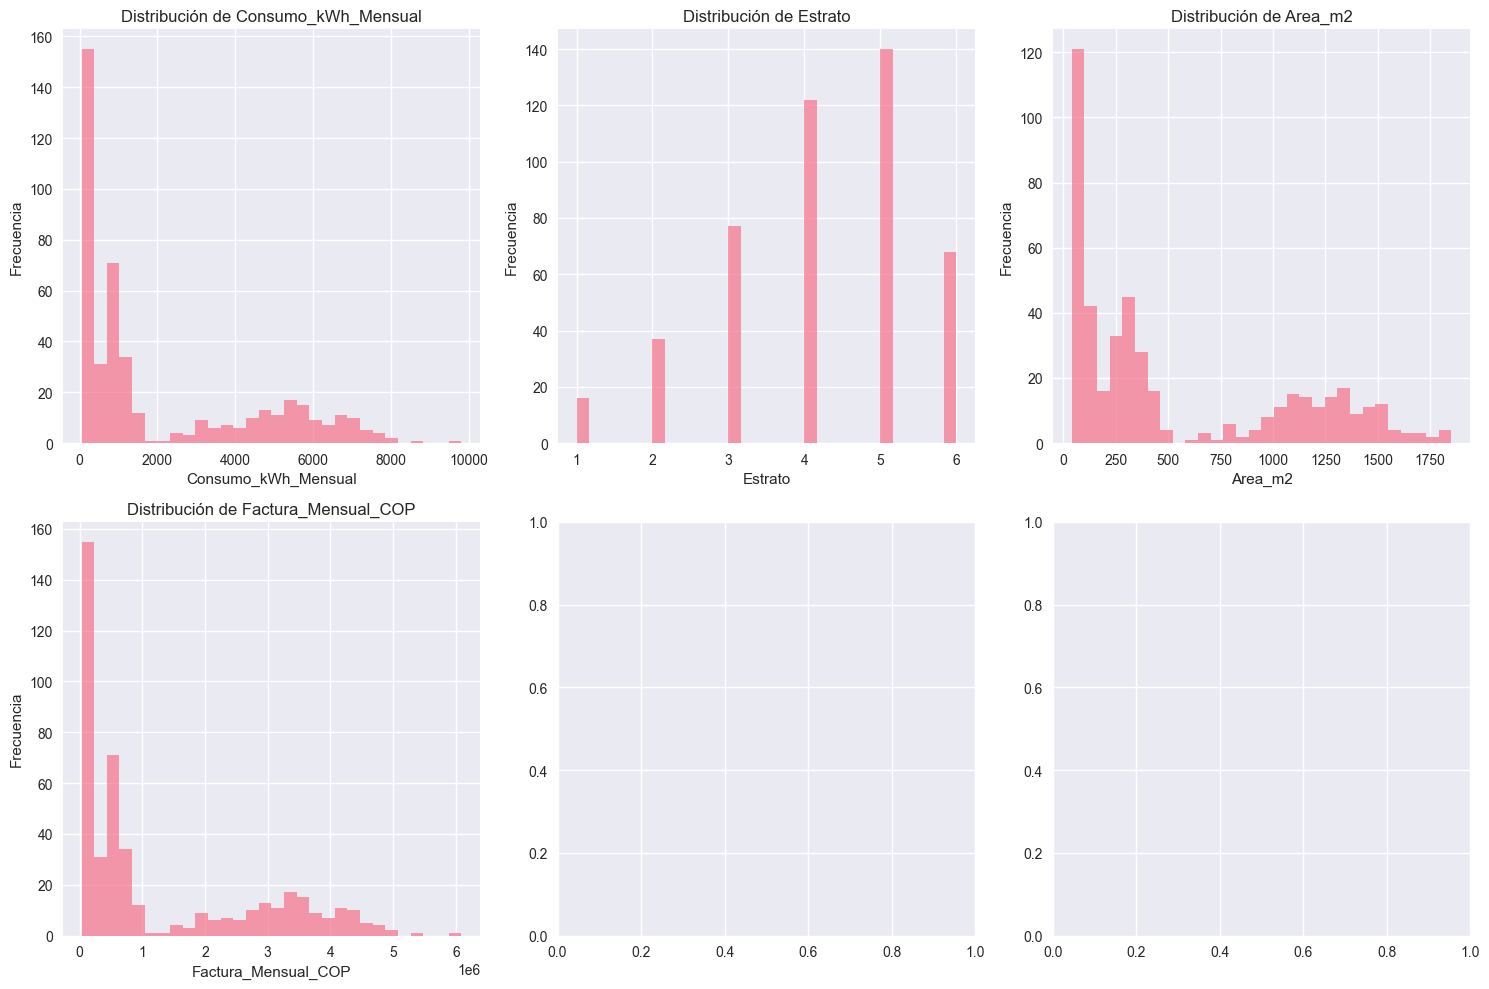

In [ ]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #de esta forma creo la figura                   
axes = axes.ravel()

for i, var in enumerate(numerical_vars[:6]):
    df[var].hist(bins=30, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

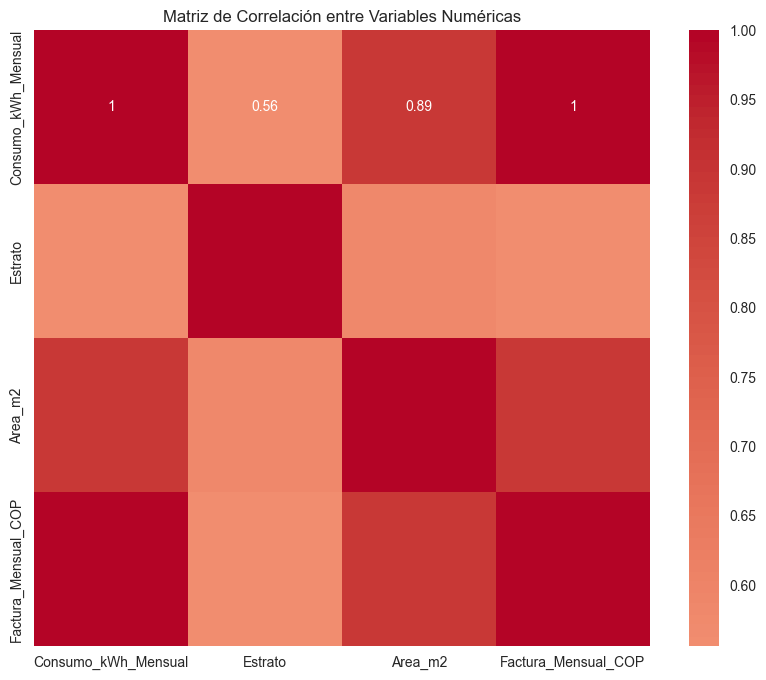

In [9]:
# Matriz de correlación
correlation_matrix = df[numerical_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

## 3. Preprocesamiento de Datos

In [7]:
# Preparar datos para modelado
df_model = df.copy()

# Eliminar variables no predictoras
features_to_drop = ['ID_Cliente', 'Validar', 'Factura_Mensual_COP']  # Factura se excluye porque está correlacionada con consumo
df_model = df_model.drop(columns=features_to_drop)

# Definir variable objetivo
target = 'Consumo_kWh_Mensual'
y = df_model[target]
X = df_model.drop(columns=[target])

print(f"Variables predictoras: {X.columns.tolist()}")
print(f"Variable objetivo: {target}")
print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")

Variables predictoras: ['Sector', 'Estrato', 'Ciudad', 'Area_m2', 'Puede_Pagar_Solar']
Variable objetivo: Consumo_kWh_Mensual
Forma de X: (460, 5), Forma de y: (460,)


In [8]:
# Codificar variables categóricas
le = LabelEncoder()
categorical_features = X.select_dtypes(include=['object']).columns

for col in categorical_features:
    X[col] = le.fit_transform(X[col].astype(str))

print("Variables categóricas codificadas:", categorical_features.tolist())
print("\nDatos después de codificación:")
print(X.head())

Variables categóricas codificadas: ['Sector', 'Ciudad', 'Puede_Pagar_Solar']

Datos después de codificación:
   Sector  Estrato  Ciudad     Area_m2  Puede_Pagar_Solar
0       2        4       3   77.234714                  0
1       2        1       4  122.833169                  0
2       2        4       3  100.210306                  0
3       2        2       1   69.496604                  0
4       2        3       1   71.444142                  0


In [9]:
# Manejo de valores nulos
print("Valores nulos antes de imputación:")
print(X.isnull().sum())
print(f"Valores nulos en y: {y.isnull().sum()}")

# Imputar valores nulos con la mediana
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Para y, eliminar filas con valores nulos
mask = ~y.isnull()
X_clean = X_imputed[mask]
y_clean = y[mask]

print(f"\nDatos finales - X: {X_clean.shape}, y: {y_clean.shape}")
print(f"Valores nulos restantes en X: {X_clean.isnull().sum().sum()}")
print(f"Valores nulos restantes en y: {y_clean.isnull().sum()}")

Valores nulos antes de imputación:
Sector               0
Estrato              0
Ciudad               0
Area_m2              0
Puede_Pagar_Solar    0
dtype: int64
Valores nulos en y: 4

Datos finales - X: (456, 5), y: (456,)
Valores nulos restantes en X: 0
Valores nulos restantes en y: 0


## 4. División de Datos (70/30)

In [10]:
# División train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42, stratify=None
)

print(f"Datos de entrenamiento: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Datos de prueba: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDatos escalados correctamente")

Datos de entrenamiento: X_train: (319, 5), y_train: (319,)
Datos de prueba: X_test: (137, 5), y_test: (137,)

Datos escalados correctamente


## 5. Modelos de Regresión

In [11]:
# Diccionario para almacenar resultados
results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """Evalúa un modelo y retorna métricas"""
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas
    metrics = {
        'R2_train': r2_score(y_train, y_pred_train),
        'R2_test': r2_score(y_test, y_pred_test),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE_train': mean_absolute_error(y_train, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test)
    }
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    metrics['CV_R2_mean'] = cv_scores.mean()
    metrics['CV_R2_std'] = cv_scores.std()
    
    return metrics, y_pred_test

### 5.1 Regresión Lineal

In [12]:
# Regresión Lineal Simple
lr = LinearRegression()
lr_metrics, lr_pred = evaluate_model('Linear Regression', lr, X_train_scaled, X_test_scaled, y_train, y_test)
results['Linear Regression'] = lr_metrics

print("=== REGRESIÓN LINEAL ===")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

=== REGRESIÓN LINEAL ===
R2_train: 0.7867
R2_test: 0.8404
RMSE_train: 1097.2151
RMSE_test: 1009.4537
MAE_train: 700.1091
MAE_test: 675.0888
CV_R2_mean: 0.7775
CV_R2_std: 0.0418


### 5.2 Regresión Ridge

In [13]:
# Ridge Regression con optimización de hiperparámetros
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')
ridge_metrics, ridge_pred = evaluate_model('Ridge', ridge, X_train_scaled, X_test_scaled, y_train, y_test)
results['Ridge'] = ridge_metrics

print("=== REGRESIÓN RIDGE ===")
print(f"Mejor alpha: {ridge.best_params_['alpha']}")
for metric, value in ridge_metrics.items():
    print(f"{metric}: {value:.4f}")

=== REGRESIÓN RIDGE ===
Mejor alpha: 1.0
R2_train: 0.7867
R2_test: 0.8405
RMSE_train: 1097.2352
RMSE_test: 1009.0338
MAE_train: 700.3184
MAE_test: 675.6020
CV_R2_mean: 0.7766
CV_R2_std: 0.0392


### 5.3 Regresión Lasso

In [14]:
# Lasso Regression con optimización de hiperparámetros
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='r2')
lasso_metrics, lasso_pred = evaluate_model('Lasso', lasso, X_train_scaled, X_test_scaled, y_train, y_test)
results['Lasso'] = lasso_metrics

print("=== REGRESIÓN LASSO ===")
print(f"Mejor alpha: {lasso.best_params_['alpha']}")
for metric, value in lasso_metrics.items():
    print(f"{metric}: {value:.4f}")

# Características seleccionadas por Lasso
lasso_coef = lasso.best_estimator_.coef_
selected_features = [X_clean.columns[i] for i in range(len(lasso_coef)) if abs(lasso_coef[i]) > 0.001]
print(f"\nCaracterísticas seleccionadas por Lasso: {selected_features}")

=== REGRESIÓN LASSO ===
Mejor alpha: 10.0
R2_train: 0.7865
R2_test: 0.8407
RMSE_train: 1097.7700
RMSE_test: 1008.6035
MAE_train: 696.2569
MAE_test: 670.6168
CV_R2_mean: 0.7778
CV_R2_std: 0.0427

Características seleccionadas por Lasso: ['Sector', 'Estrato', 'Ciudad', 'Area_m2', 'Puede_Pagar_Solar']


### 5.4 Regresión ElasticNet

In [15]:
# ElasticNet Regression con optimización de hiperparámetros
elastic_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}
elastic = GridSearchCV(ElasticNet(), elastic_params, cv=5, scoring='r2')
elastic_metrics, elastic_pred = evaluate_model('ElasticNet', elastic, X_train_scaled, X_test_scaled, y_train, y_test)
results['ElasticNet'] = elastic_metrics

print("=== REGRESIÓN ELASTICNET ===")
print(f"Mejores parámetros: {elastic.best_params_}")
for metric, value in elastic_metrics.items():
    print(f"{metric}: {value:.4f}")

=== REGRESIÓN ELASTICNET ===
Mejores parámetros: {'alpha': 0.1, 'l1_ratio': 0.9}
R2_train: 0.7866
R2_test: 0.8408
RMSE_train: 1097.4175
RMSE_test: 1008.2887
MAE_train: 700.9094
MAE_test: 676.8412
CV_R2_mean: 0.7769
CV_R2_std: 0.0388


### 5.5 Decision Tree

In [16]:
# Decision Tree con optimización de hiperparámetros
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='r2')
dt_metrics, dt_pred = evaluate_model('Decision Tree', dt, X_train, X_test, y_train, y_test)
results['Decision Tree'] = dt_metrics

print("=== DECISION TREE ===")
print(f"Mejores parámetros: {dt.best_params_}")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value:.4f}")

=== DECISION TREE ===
Mejores parámetros: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
R2_train: 0.8656
R2_test: 0.8448
RMSE_train: 871.0876
RMSE_test: 995.3994
MAE_train: 493.2712
MAE_test: 581.4119
CV_R2_mean: 0.8129
CV_R2_std: 0.0930


### 5.6 Random Forest

In [17]:
# Random Forest con optimización de hiperparámetros
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2')
rf_metrics, rf_pred = evaluate_model('Random Forest', rf, X_train, X_test, y_train, y_test)
results['Random Forest'] = rf_metrics

print("=== RANDOM FOREST ===")
print(f"Mejores parámetros: {rf.best_params_}")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

# Importancia de características+-
feature_importance = pd.DataFrame({
    'feature': X_clean.columns,
    'importance': rf.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportancia de características:")
print(feature_importance)

=== RANDOM FOREST ===
Mejores parámetros: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
R2_train: 0.8684
R2_test: 0.8530
RMSE_train: 861.8183
RMSE_test: 968.7818
MAE_train: 483.0233
MAE_test: 559.0940
CV_R2_mean: 0.8244
CV_R2_std: 0.0804

Importancia de características:
             feature  importance
3            Area_m2    0.975060
0             Sector    0.018119
2             Ciudad    0.004466
1            Estrato    0.001910
4  Puede_Pagar_Solar    0.000445


### 5.7 Gradient Boosting

In [18]:
# Gradient Boosting con optimización de hiperparámetros
gb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
gb = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5, scoring='r2')
gb_metrics, gb_pred = evaluate_model('Gradient Boosting', gb, X_train, X_test, y_train, y_test)
results['Gradient Boosting'] = gb_metrics

print("=== GRADIENT BOOSTING ===")
print(f"Mejores parámetros: {gb.best_params_}")
for metric, value in gb_metrics.items():
    print(f"{metric}: {value:.4f}")

=== GRADIENT BOOSTING ===
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
R2_train: 0.9134
R2_test: 0.8196
RMSE_train: 699.0887
RMSE_test: 1073.0718
MAE_train: 411.3240
MAE_test: 634.8381
CV_R2_mean: 0.7793
CV_R2_std: 0.0514


## 6. Comparación de Modelos

In [19]:
# Crear DataFrame con resultados
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("=== COMPARACIÓN DE MODELOS ===")
print(results_df)

# Ordenar por R2 de test
results_sorted = results_df.sort_values('R2_test', ascending=False)
print("\n=== RANKING POR R2 DE TEST ===")
print(results_sorted[['R2_test', 'RMSE_test', 'MAE_test', 'CV_R2_mean']])

=== COMPARACIÓN DE MODELOS ===
                   R2_train  R2_test  RMSE_train  RMSE_test  MAE_train  \
Linear Regression    0.7867   0.8404   1097.2151  1009.4537   700.1091   
Ridge                0.7867   0.8405   1097.2352  1009.0338   700.3184   
Lasso                0.7865   0.8407   1097.7700  1008.6035   696.2569   
ElasticNet           0.7866   0.8408   1097.4175  1008.2887   700.9094   
Decision Tree        0.8656   0.8448    871.0876   995.3994   493.2712   
Random Forest        0.8684   0.8530    861.8183   968.7818   483.0233   
Gradient Boosting    0.9134   0.8196    699.0887  1073.0718   411.3240   

                   MAE_test  CV_R2_mean  CV_R2_std  
Linear Regression  675.0888      0.7775     0.0418  
Ridge              675.6020      0.7766     0.0392  
Lasso              670.6168      0.7778     0.0427  
ElasticNet         676.8412      0.7769     0.0388  
Decision Tree      581.4119      0.8129     0.0930  
Random Forest      559.0940      0.8244     0.0804  
Gradi

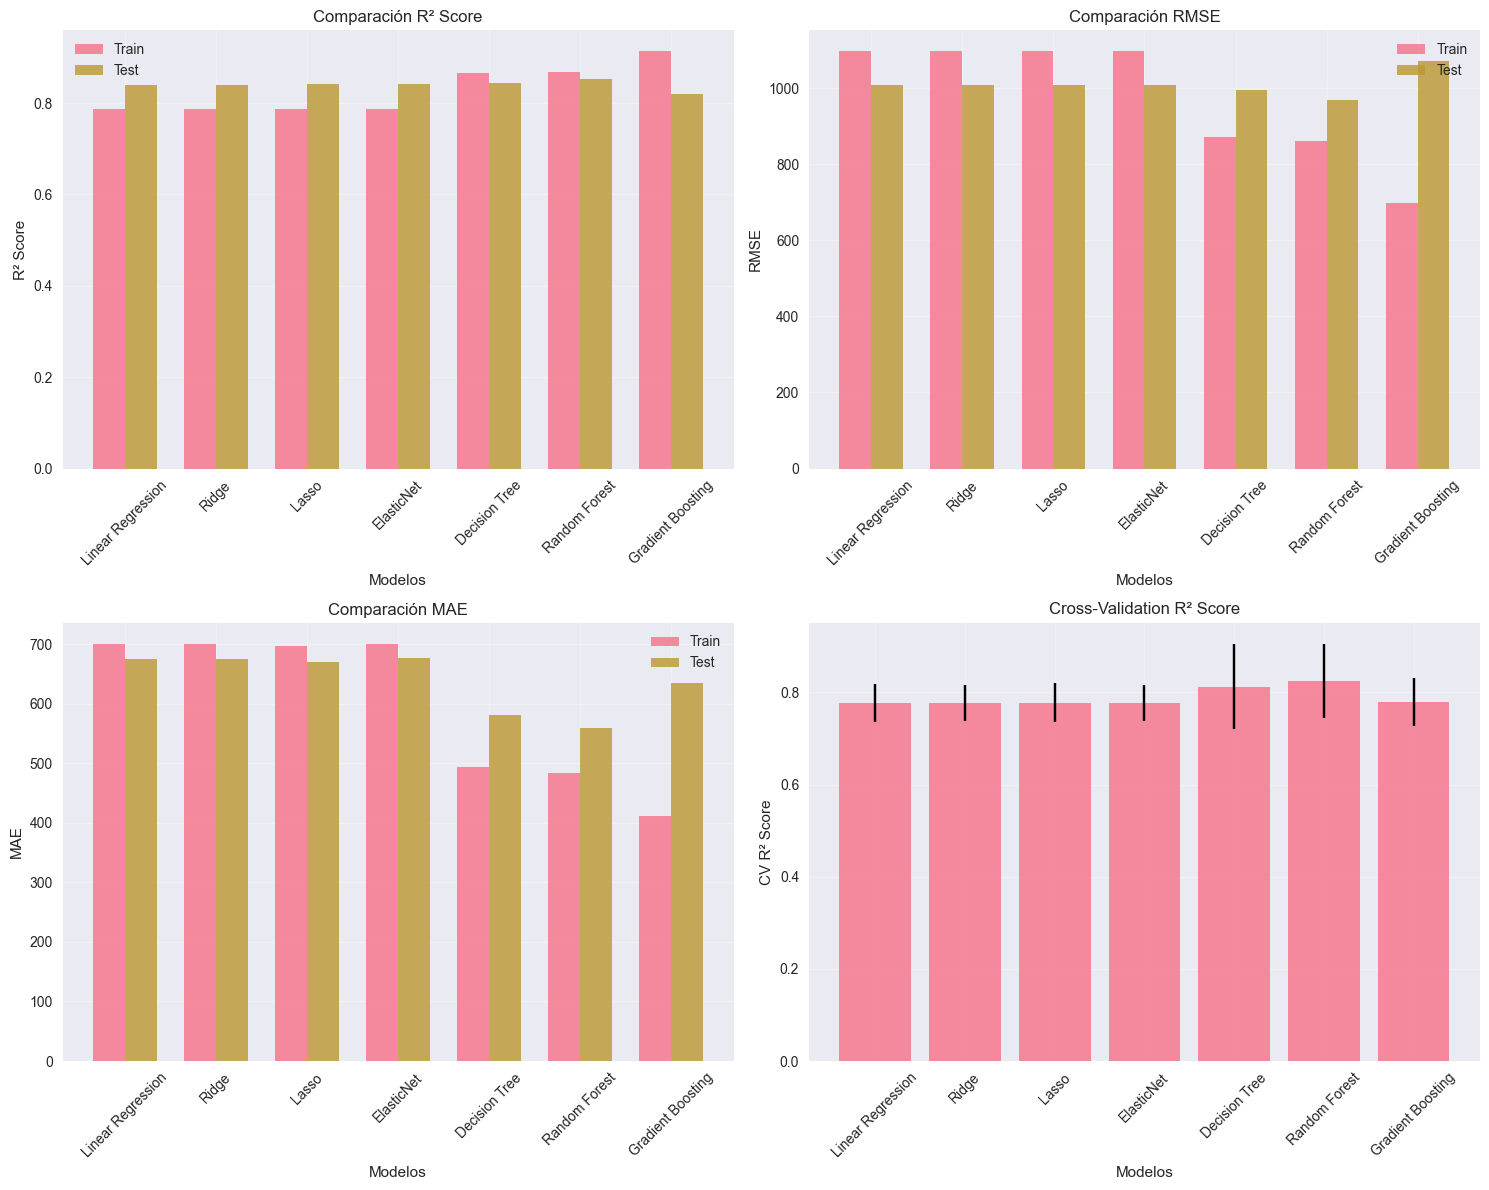

In [20]:
# Visualización de comparación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R2 Score
models = list(results.keys())
r2_train = [results[model]['R2_train'] for model in models]
r2_test = [results[model]['R2_test'] for model in models]

x = np.arange(len(models))
width = 0.35

axes[0,0].bar(x - width/2, r2_train, width, label='Train', alpha=0.8)
axes[0,0].bar(x + width/2, r2_test, width, label='Test', alpha=0.8)
axes[0,0].set_xlabel('Modelos')
axes[0,0].set_ylabel('R² Score')
axes[0,0].set_title('Comparación R² Score')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(models, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# RMSE
rmse_train = [results[model]['RMSE_train'] for model in models]
rmse_test = [results[model]['RMSE_test'] for model in models]

axes[0,1].bar(x - width/2, rmse_train, width, label='Train', alpha=0.8)
axes[0,1].bar(x + width/2, rmse_test, width, label='Test', alpha=0.8)
axes[0,1].set_xlabel('Modelos')
axes[0,1].set_ylabel('RMSE')
axes[0,1].set_title('Comparación RMSE')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(models, rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# MAE
mae_train = [results[model]['MAE_train'] for model in models]
mae_test = [results[model]['MAE_test'] for model in models]

axes[1,0].bar(x - width/2, mae_train, width, label='Train', alpha=0.8)
axes[1,0].bar(x + width/2, mae_test, width, label='Test', alpha=0.8)
axes[1,0].set_xlabel('Modelos')
axes[1,0].set_ylabel('MAE')
axes[1,0].set_title('Comparación MAE')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Cross-validation R2
cv_r2_mean = [results[model]['CV_R2_mean'] for model in models]
cv_r2_std = [results[model]['CV_R2_std'] for model in models]

axes[1,1].bar(x, cv_r2_mean, yerr=cv_r2_std, capsize=5, alpha=0.8)
axes[1,1].set_xlabel('Modelos')
axes[1,1].set_ylabel('CV R² Score')
axes[1,1].set_title('Cross-Validation R² Score')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(models, rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# Crear reporte Excel automatizado
def generar_reporte_excel(best_model_name=None, best_predictions=None, results_sorted=None,
                         y_test=None, X_train=None, X_test=None, df=None, X_clean=None):
    """Genera un reporte completo en Excel con todos los resultados del análisis"""

    # Nombre del archivo
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'Reporte_Consumo_ML_{timestamp}.xlsx'

    # Crear workbook
    wb = Workbook()

    # Estilos
    header_fill = PatternFill(start_color="4CAF50", end_color="4CAF50", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF", size=12)
    title_font = Font(bold=True, size=14, color="1F4788")
    border = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )

    # ============ HOJA 1: RESUMEN EJECUTIVO ============
    ws1 = wb.active
    ws1.title = "Resumen Ejecutivo"

    # Título
    ws1['A1'] = 'REPORTE DE PREDICCIÓN DE CONSUMO ENERGÉTICO - MACHINE LEARNING'
    ws1['A1'].font = Font(bold=True, size=16, color="1F4788")
    ws1.merge_cells('A1:D1')

    ws1['A2'] = f'Fecha de generación: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
    ws1['A2'].font = Font(italic=True)
    ws1.merge_cells('A2:D2')

    # Información del dataset
    row = 4
    ws1[f'A{row}'] = 'INFORMACIÓN DEL DATASET'
    ws1[f'A{row}'].font = title_font
    row += 1

    dataset_info = [
        ['Total de registros:', df.shape[0]],
        ['Registros válidos para modelado:', X_clean.shape[0]],
        ['Variables predictoras:', X_clean.shape[1]],
        ['División entrenamiento:', f'{X_train.shape[0]} ({X_train.shape[0]/X_clean.shape[0]*100:.1f}%)'],
        ['División prueba:', f'{X_test.shape[0]} ({X_test.shape[0]/X_clean.shape[0]*100:.1f}%)'],
    ]

    for item in dataset_info:
        ws1[f'A{row}'] = item[0]
        ws1[f'B{row}'] = item[1]
        ws1[f'A{row}'].font = Font(bold=True)
        row += 1

    # Mejor modelo
    row += 2
    ws1[f'A{row}'] = 'MEJOR MODELO SELECCIONADO'
    ws1[f'A{row}'].font = title_font
    row += 1

    ws1[f'A{row}'] = 'Modelo:'
    ws1[f'B{row}'] = best_model_name
    ws1[f'A{row}'].font = Font(bold=True)
    ws1[f'B{row}'].font = Font(bold=True, size=12, color="006400")
    row += 1

    best_model_info = [
        ['R² Score (Test):', f"{results_sorted.loc[best_model_name, 'R2_test']:.4f}"],
        ['RMSE (Test):', f"{results_sorted.loc[best_model_name, 'RMSE_test']:.2f}"],
        ['MAE (Test):', f"{results_sorted.loc[best_model_name, 'MAE_test']:.2f}"],
        ['CV R² Media:', f"{results_sorted.loc[best_model_name, 'CV_R2_mean']:.4f}"],
        ['CV R² Std:', f"{results_sorted.loc[best_model_name, 'CV_R2_std']:.4f}"],
    ]

    for item in best_model_info:
        ws1[f'A{row}'] = item[0]
        ws1[f'B{row}'] = item[1]
        ws1[f'A{row}'].font = Font(bold=True)
        row += 1

    # Top 3 modelos
    row += 2
    ws1[f'A{row}'] = 'TOP 3 MODELOS'
    ws1[f'A{row}'].font = title_font
    row += 1

    # Encabezados
    headers = ['Ranking', 'Modelo', 'R² Test', 'RMSE Test', 'MAE Test']
    for col, header in enumerate(headers, start=1):
        cell = ws1.cell(row=row, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border
    row += 1

    # Datos top 3
    for i, (model_name, metrics) in enumerate(results_sorted.head(3).iterrows(), start=1):
        ws1[f'A{row}'] = i
        ws1[f'B{row}'] = model_name
        ws1[f'C{row}'] = f"{metrics['R2_test']:.4f}"
        ws1[f'D{row}'] = f"{metrics['RMSE_test']:.2f}"
        ws1[f'E{row}'] = f"{metrics['MAE_test']:.2f}"

        for col in range(1, 6):
            ws1.cell(row=row, column=col).border = border
            ws1.cell(row=row, column=col).alignment = Alignment(horizontal='center')
        row += 1

    # Ajustar anchos
    ws1.column_dimensions['A'].width = 25
    ws1.column_dimensions['B'].width = 20
    ws1.column_dimensions['C'].width = 15
    ws1.column_dimensions['D'].width = 15
    ws1.column_dimensions['E'].width = 15

    # ============ HOJA 2: COMPARACIÓN DE MODELOS ============
    ws2 = wb.create_sheet("Comparación Modelos")

    ws2['A1'] = 'COMPARACIÓN DETALLADA DE MODELOS'
    ws2['A1'].font = title_font
    ws2.merge_cells('A1:I1')

    # Encabezados
    headers = ['Modelo', 'R² Train', 'R² Test', 'RMSE Train', 'RMSE Test',
               'MAE Train', 'MAE Test', 'CV R² Mean', 'CV R² Std']
    for col, header in enumerate(headers, start=1):
        cell = ws2.cell(row=3, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border

    # Datos
    row = 4
    for model_name, metrics in results_sorted.iterrows():
        ws2[f'A{row}'] = model_name
        ws2[f'B{row}'] = f"{metrics['R2_train']:.4f}"
        ws2[f'C{row}'] = f"{metrics['R2_test']:.4f}"
        ws2[f'D{row}'] = f"{metrics['RMSE_train']:.2f}"
        ws2[f'E{row}'] = f"{metrics['RMSE_test']:.2f}"
        ws2[f'F{row}'] = f"{metrics['MAE_train']:.2f}"
        ws2[f'G{row}'] = f"{metrics['MAE_test']:.2f}"
        ws2[f'H{row}'] = f"{metrics['CV_R2_mean']:.4f}"
        ws2[f'I{row}'] = f"{metrics['CV_R2_std']:.4f}"

        # Resaltar mejor modelo
        if model_name == best_model_name:
            for col in range(1, 10):
                ws2.cell(row=row, column=col).fill = PatternFill(
                    start_color="C6EFCE", end_color="C6EFCE", fill_type="solid"
                )

        for col in range(1, 10):
            ws2.cell(row=row, column=col).border = border
            ws2.cell(row=row, column=col).alignment = Alignment(horizontal='center')
        row += 1

    # Ajustar anchos
    for col in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
        ws2.column_dimensions[col].width = 15

    # ============ HOJA 3: PREDICCIONES Y ERRORES ============
    ws3 = wb.create_sheet("Predicciones")

    ws3['A1'] = 'PREDICCIONES DEL MEJOR MODELO'
    ws3['A1'].font = title_font
    ws3.merge_cells('A1:F1')

    ws3['A2'] = f'Modelo: {best_model_name}'
    ws3['A2'].font = Font(bold=True)
    ws3.merge_cells('A2:F2')

    # Crear DataFrame con predicciones
    predicciones_df = pd.DataFrame({
        'ID': range(1, len(y_test) + 1),
        'Consumo Real': y_test.values,
        'Consumo Predicha': best_predictions,
        'Error (Residuo)': y_test.values - best_predictions,
        'Error Absoluto': np.abs(y_test.values - best_predictions),
        'Error Porcentual (%)': np.abs((y_test.values - best_predictions) / y_test.values * 100)
    })

    # Encabezados
    row = 4
    for col, header in enumerate(predicciones_df.columns, start=1):
        cell = ws3.cell(row=row, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border

    # Datos
    for r_idx, row_data in enumerate(dataframe_to_rows(predicciones_df, index=False, header=False), start=5):
        for c_idx, value in enumerate(row_data, start=1):
            cell = ws3.cell(row=r_idx, column=c_idx)
            if isinstance(value, (int, float)):
                cell.value = round(value, 2)
            else:
                cell.value = value
            cell.border = border
            cell.alignment = Alignment(horizontal='center')

            # Colorear según error
            if c_idx == 6 and isinstance(value, (int, float)):  # Error porcentual
                if value > 20:
                    cell.fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")
                elif value > 10:
                    cell.fill = PatternFill(start_color="FFEB9C", end_color="FFEB9C", fill_type="solid")
                else:
                    cell.fill = PatternFill(start_color="C6EFCE", end_color="C6EFCE", fill_type="solid")

    # Estadísticas de error
    stats_row = len(predicciones_df) + 7
    ws3[f'A{stats_row}'] = 'ESTADÍSTICAS DE ERROR'
    ws3[f'A{stats_row}'].font = title_font

    stats_row += 1
    error_stats = [
        ['Error Medio:', f"{predicciones_df['Error (Residuo)'].mean():.2f}"],
        ['Error Absoluto Medio (MAE):', f"{predicciones_df['Error Absoluto'].mean():.2f}"],
        ['Error Cuadrático Medio (RMSE):', f"{np.sqrt((predicciones_df['Error (Residuo)']**2).mean()):.2f}"],
        ['Error Porcentual Medio:', f"{predicciones_df['Error Porcentual (%)'].mean():.2f}%"],
        ['R² Score:', f"{r2_score(y_test, best_predictions):.4f}"],
    ]

    for item in error_stats:
        ws3[f'A{stats_row}'] = item[0]
        ws3[f'B{stats_row}'] = item[1]
        ws3[f'A{stats_row}'].font = Font(bold=True)
        stats_row += 1

    # Ajustar anchos
    for col in ['A', 'B', 'C', 'D', 'E', 'F']:
        ws3.column_dimensions[col].width = 18

    # ============ HOJA 4: VARIABLES PREDICTORAS ============
    ws4 = wb.create_sheet("Variables Predictoras")

    ws4['A1'] = 'VARIABLES PREDICTORAS UTILIZADAS'
    ws4['A1'].font = title_font
    ws4.merge_cells('A1:C1')

    # Variables
    row = 3
    ws4[f'A{row}'] = 'Variable'
    ws4[f'B{row}'] = 'Tipo'
    ws4[f'C{row}'] = 'Descripción'
    for col in ['A', 'B', 'C']:
        ws4[f'{col}{row}'].font = header_font
        ws4[f'{col}{row}'].fill = header_fill
        ws4[f'{col}{row}'].alignment = Alignment(horizontal='center')
        ws4[f'{col}{row}'].border = border

    row += 1
    variables_info = [
        ['NDVI Outlier Manual', 'Numérica', 'Índice de Vegetación de Diferencia Normalizada'],
        ['NDRE Outlier Manual', 'Numérica', 'Índice de Borde Rojo de Diferencia Normalizada'],
        ['PRECIPITACION Outlier Manual', 'Numérica', 'Precipitación en mm'],
        ['DIAS SIN LLUVIA Estadistica', 'Numérica', 'Días consecutivos sin lluvia'],
        ['Tipo_suelo', 'Categórica', 'Tipo de suelo (Arenoso, Arcilloso, Franco)'],
    ]

    for var_info in variables_info:
        ws4[f'A{row}'] = var_info[0]
        ws4[f'B{row}'] = var_info[1]
        ws4[f'C{row}'] = var_info[2]
        for col in ['A', 'B', 'C']:
            ws4[f'{col}{row}'].border = border
        row += 1

    # Ajustar anchos
    ws4.column_dimensions['A'].width = 30
    ws4.column_dimensions['B'].width = 15
    ws4.column_dimensions['C'].width = 50

    # Guardar archivo
    wb.save(filename)

    print(f"✓ Reporte generado exitosamente: {filename}")
    print(f"  - Hoja 1: Resumen Ejecutivo")
    print(f"  - Hoja 2: Comparación de Modelos")
    print(f"  - Hoja 3: Predicciones y Errores")
    print(f"  - Hoja 4: Variables Predictoras")

    return filename


# Verificar y definir variables necesarias
if 'best_model_name' not in globals() or best_model_name is None:
    best_model_name = results_sorted.index[0]

# Obtener predicciones del mejor modelo
if best_model_name == 'Random Forest':
    best_predictions = rf_pred
    best_model = rf
elif best_model_name == 'Gradient Boosting':
    best_predictions = gb_pred
    best_model = gb
elif best_model_name == 'Decision Tree':
    best_predictions = dt_pred
    best_model = dt
elif best_model_name == 'Linear Regression':
    best_predictions = lr_pred
    best_model = lr
elif best_model_name == 'Ridge':
    best_predictions = ridge_pred
    best_model = ridge
elif best_model_name == 'Lasso':
    best_predictions = lasso_pred
    best_model = lasso
else:  # ElasticNet
    best_predictions = elastic_pred
    best_model = elastic


# Generar reporte (solo si las variables están definidas)
if 'best_model_name' in globals() and 'results_sorted' in globals():
    archivo_reporte = generar_reporte_excel(best_model_name, best_predictions, results_sorted, y_test, X_train, X_test, df, X_clean)
else:
    print('⚠ Ejecute primero las celdas anteriores que entrenan y evalúan los modelos')
    print('  Luego ejecute esta celda nuevamente para generar el reporte')


✓ Reporte generado exitosamente: Reporte_Consumo_ML_20251114_125355.xlsx
  - Hoja 1: Resumen Ejecutivo
  - Hoja 2: Comparación de Modelos
  - Hoja 3: Predicciones y Errores
  - Hoja 4: Variables Predictoras


## 6.6 Generación Automatizada de Reportes en Excel

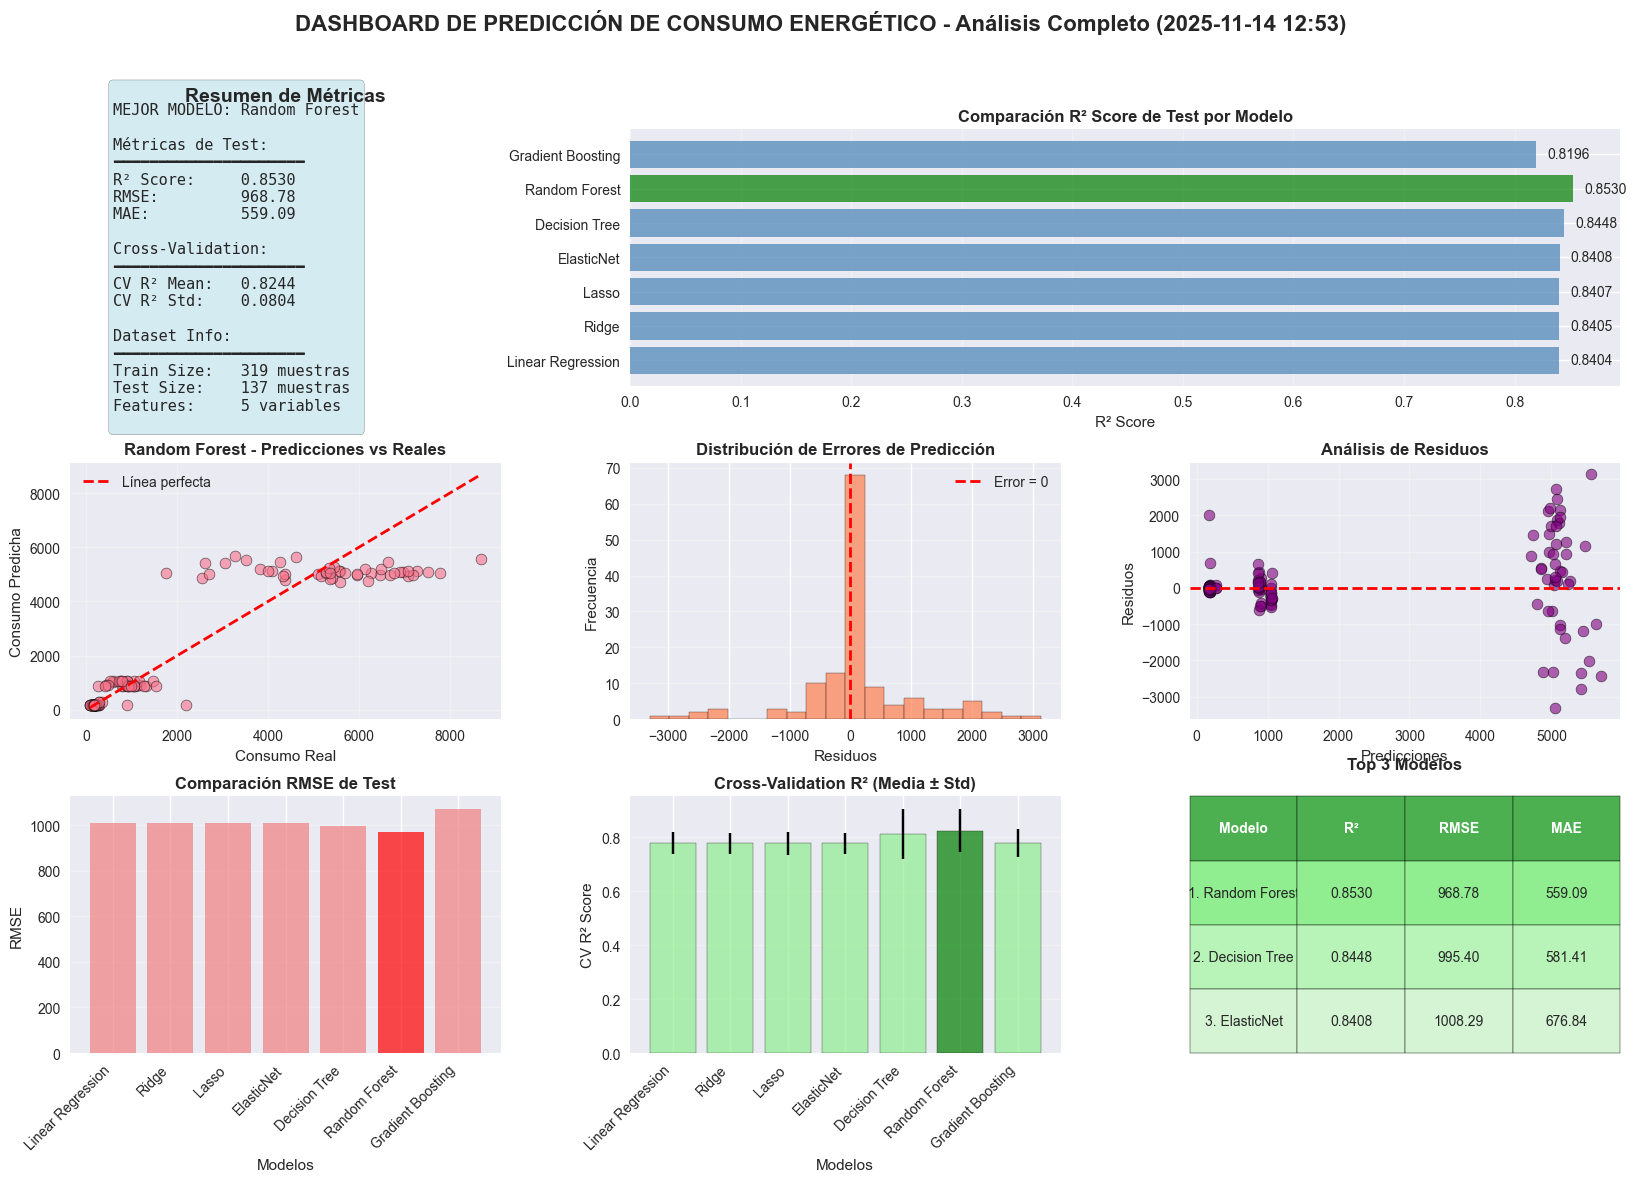

✓ Dashboard generado exitosamente


In [22]:
# Identificar el mejor modelo
best_model_name = results_sorted.index[0]

# Obtener predicciones del mejor modelo
if best_model_name == 'Random Forest':
    best_predictions = rf_pred
    best_model = rf
elif best_model_name == 'Gradient Boosting':
    best_predictions = gb_pred
    best_model = gb
elif best_model_name == 'Decision Tree':
    best_predictions = dt_pred
    best_model = dt
elif best_model_name == 'Linear Regression':
    best_predictions = lr_pred
    best_model = lr
elif best_model_name == 'Ridge':
    best_predictions = ridge_pred
    best_model = ridge
elif best_model_name == 'Lasso':
    best_predictions = lasso_pred
    best_model = lasso
else:  # ElasticNet
    best_predictions = elastic_pred
    best_model = elastic


# Dashboard completo de resultados
from datetime import datetime

# Crear figura con subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Métricas del mejor modelo (superior izquierda)
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
best_metrics_text = f"""
MEJOR MODELO: {best_model_name}

Métricas de Test:
━━━━━━━━━━━━━━━━━━━━━
R² Score:     {results_sorted.loc[best_model_name, 'R2_test']:.4f}
RMSE:         {results_sorted.loc[best_model_name, 'RMSE_test']:.2f}
MAE:          {results_sorted.loc[best_model_name, 'MAE_test']:.2f}

Cross-Validation:
━━━━━━━━━━━━━━━━━━━━━
CV R² Mean:   {results_sorted.loc[best_model_name, 'CV_R2_mean']:.4f}
CV R² Std:    {results_sorted.loc[best_model_name, 'CV_R2_std']:.4f}

Dataset Info:
━━━━━━━━━━━━━━━━━━━━━
Train Size:   {X_train.shape[0]} muestras
Test Size:    {X_test.shape[0]} muestras
Features:     {X_train.shape[1]} variables
"""
ax1.text(0.1, 0.5, best_metrics_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax1.set_title('Resumen de Métricas', fontsize=14, fontweight='bold', pad=20)

# 2. Comparación R² de todos los modelos (superior centro y derecha)
ax2 = fig.add_subplot(gs[0, 1:])
models_list = list(results.keys())
r2_test_values = [results[model]['R2_test'] for model in models_list]
colors = ['green' if model == best_model_name else 'steelblue' for model in models_list]

bars = ax2.barh(models_list, r2_test_values, color=colors, alpha=0.7)
ax2.set_xlabel('R² Score', fontsize=11)
ax2.set_title('Comparación R² Score de Test por Modelo', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(r2_test_values):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# 3. Predicciones vs Valores Reales (medio izquierda)
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_test, best_predictions, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Línea perfecta')
ax3.set_xlabel('Consumo Real', fontsize=11)
ax3.set_ylabel('Consumo Predicha', fontsize=11)
ax3.set_title(f'{best_model_name} - Predicciones vs Reales', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Distribución de residuos (medio centro)
ax4 = fig.add_subplot(gs[1, 1])
residuals = y_test.values - best_predictions
ax4.hist(residuals, bins=20, alpha=0.7, color='coral', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
ax4.set_xlabel('Residuos', fontsize=11)
ax4.set_ylabel('Frecuencia', fontsize=11)
ax4.set_title('Distribución de Errores de Predicción', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Residuos vs Predicciones (medio derecha)
ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(best_predictions, residuals, alpha=0.6, s=60, color='purple', edgecolors='black', linewidth=0.5)
ax5.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Predicciones', fontsize=11)
ax5.set_ylabel('Residuos', fontsize=11)
ax5.set_title('Análisis de Residuos', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Comparación RMSE (inferior izquierda)
ax6 = fig.add_subplot(gs[2, 0])
rmse_test_values = [results[model]['RMSE_test'] for model in models_list]
colors_rmse = ['red' if model == best_model_name else 'lightcoral' for model in models_list]
ax6.bar(range(len(models_list)), rmse_test_values, color=colors_rmse, alpha=0.7)
ax6.set_xlabel('Modelos', fontsize=11)
ax6.set_ylabel('RMSE', fontsize=11)
ax6.set_title('Comparación RMSE de Test', fontsize=12, fontweight='bold')
ax6.set_xticks(range(len(models_list)))
ax6.set_xticklabels(models_list, rotation=45, ha='right')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Cross-Validation Scores (inferior centro)
ax7 = fig.add_subplot(gs[2, 1])
cv_means = [results[model]['CV_R2_mean'] for model in models_list]
cv_stds = [results[model]['CV_R2_std'] for model in models_list]
colors_cv = ['green' if model == best_model_name else 'lightgreen' for model in models_list]
ax7.bar(range(len(models_list)), cv_means, yerr=cv_stds, capsize=5, 
        color=colors_cv, alpha=0.7, edgecolor='black')
ax7.set_xlabel('Modelos', fontsize=11)
ax7.set_ylabel('CV R² Score', fontsize=11)
ax7.set_title('Cross-Validation R² (Media ± Std)', fontsize=12, fontweight='bold')
ax7.set_xticks(range(len(models_list)))
ax7.set_xticklabels(models_list, rotation=45, ha='right')
ax7.grid(True, alpha=0.3, axis='y')

# 8. Tabla resumen top 3 modelos (inferior derecha)
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('tight')
ax8.axis('off')

top3_data = []
for i, (model_name, metrics) in enumerate(results_sorted.head(3).iterrows()):
    top3_data.append([
        f"{i+1}. {model_name}",
        f"{metrics['R2_test']:.4f}",
        f"{metrics['RMSE_test']:.2f}",
        f"{metrics['MAE_test']:.2f}"
    ])

table = ax8.table(cellText=top3_data,
                 colLabels=['Modelo', 'R²', 'RMSE', 'MAE'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilizar encabezados
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Estilizar filas
colors_table = ['#90EE90', '#B8F4B8', '#D4F4D4']
for i in range(1, 4):
    for j in range(4):
        table[(i, j)].set_facecolor(colors_table[i-1])

ax8.set_title('Top 3 Modelos', fontsize=12, fontweight='bold', pad=20)

# Título general del dashboard
fig.suptitle(f'DASHBOARD DE PREDICCIÓN DE CONSUMO ENERGÉTICO - Análisis Completo ({datetime.now().strftime("%Y-%m-%d %H:%M")})', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

print("✓ Dashboard generado exitosamente")

## 6.5 Dashboard de Visualización de Resultados

## 7. Análisis del Mejor Modelo

In [23]:
import os
from pathlib import Path

# Resumen completo de archivos generados
def mostrar_resumen_archivos():
    """Muestra un resumen completo de todos los archivos generados durante el análisis"""
    
    print("\n" + "=" * 80)
    print("📋 RESUMEN DE ARCHIVOS GENERADOS - ANÁLISIS DE PREDICCIÓN DE CONSUMO ENERGÉTICO")
    print("=" * 80)
    print(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Mejor modelo seleccionado: {best_model_name}")
    print(f"Métricas del modelo: R²={results_sorted.loc[best_model_name, 'R2_test']:.4f}, " + 
          f"RMSE={results_sorted.loc[best_model_name, 'RMSE_test']:.2f}")
    print("=" * 80)
    
    # Recolectar información de archivos
    archivos_info = []
    
    # 1. Modelo guardado
    if 'archivos_modelo' in globals():
        pkl_file, joblib_file, json_file = archivos_modelo
        
        archivos_info.append({
            'categoria': '🤖 MODELO ENTRENADO',
            'archivos': [
                {'nombre': pkl_file, 'descripcion': 'Modelo en formato Pickle'},
                {'nombre': joblib_file, 'descripcion': 'Modelo en formato Joblib (recomendado)'},
                {'nombre': json_file, 'descripcion': 'Metadatos del modelo en JSON'}
            ]
        })
    
    # 2. Reporte Excel
    if 'archivo_reporte' in globals():
        archivos_info.append({
            'categoria': '📊 REPORTE DE ANÁLISIS',
            'archivos': [
                {'nombre': archivo_reporte, 'descripcion': 'Reporte completo con 4 hojas (Ejecutivo, Modelos, Predicciones, Variables)'}
            ]
        })
    
    # 3. Archivo de ejemplo
    if 'archivo_ejemplo' in globals():
        archivos_info.append({
            'categoria': '📝 DATOS DE EJEMPLO',
            'archivos': [
                {'nombre': archivo_ejemplo, 'descripcion': 'Plantilla con datos de ejemplo para predicciones'}
            ]
        })
    
    # 4. Predicciones realizadas
    if 'archivo_predicciones' in globals():
        archivos_info.append({
            'categoria': '🔮 PREDICCIONES',
            'archivos': [
                {'nombre': archivo_predicciones, 'descripcion': 'Resultados de predicciones con datos de ejemplo'}
            ]
        })
    
    # Mostrar información organizada
    contador = 0
    for grupo in archivos_info:
        print(f"\n{grupo['categoria']}")
        print("-" * 80)
        for archivo in grupo['archivos']:
            contador += 1
            nombre = archivo['nombre']
            desc = archivo['descripcion']
            
            # Verificar si existe y obtener tamaño
            if os.path.exists(nombre):
                tamaño = os.path.getsize(nombre)
                if tamaño < 1024:
                    tamaño_str = f"{tamaño} bytes"
                elif tamaño < 1024 * 1024:
                    tamaño_str = f"{tamaño/1024:.2f} KB"
                else:
                    tamaño_str = f"{tamaño/(1024*1024):.2f} MB"
                
                print(f"  {contador}. ✓ {nombre}")
                print(f"     → {desc}")
                print(f"     → Tamaño: {tamaño_str}")
            else:
                print(f"  {contador}. ⚠ {nombre} (no encontrado)")
                print(f"     → {desc}")
    
    # Resumen final
    print("\n" + "=" * 80)
    print(f"TOTAL DE ARCHIVOS GENERADOS: {contador}")
    print("=" * 80)
    
    # Tabla resumen
    print("\n📦 CONTENIDO DE LOS ARCHIVOS:")
    print("-" * 80)
    
    resumen_contenido = [
        ["Archivo", "Contenido Principal"],
        ["-" * 35, "-" * 43],
        ["Modelo (.pkl/.joblib)", "Modelo entrenado + Scaler + Imputer + LabelEncoder"],
        ["Metadatos (.json)", "Información del modelo, métricas y parámetros"],
        ["Reporte Excel", "4 hojas: Resumen, Comparación, Predicciones, Variables"],
        ["Datos Ejemplo", "Plantilla para nuevas predicciones (10 registros)"],
        ["Predicciones Excel", "Resultados + Estadísticas de predicciones"],
    ]
    
    for fila in resumen_contenido:
        print(f"  {fila[0]:<35} | {fila[1]:<43}")
    
    print("\n" + "=" * 80)
    print("💡 INSTRUCCIONES DE USO:")
    print("-" * 80)
    print("""
  1. PARA REALIZAR NUEVAS PREDICCIONES:
     • Prepare un archivo Excel con las columnas requeridas
     • Use: predecir_desde_excel('su_archivo.xlsx')
     
  2. PARA CARGAR EL MODELO EN OTRA SESIÓN:
     • import joblib
     • modelo = joblib.load('archivo_modelo.joblib')
     • predicciones = modelo['modelo'].predict(datos_nuevos)
     
  3. PARA REVISAR RESULTADOS:
     • Abra el archivo de reporte Excel
     • Revise cada hoja para análisis detallado
     
  4. PARA COMPARTIR EL MODELO:
     • Envíe el archivo .joblib y el .json
     • El receptor necesitará scikit-learn instalado
""")
    print("=" * 80)
    
    # Guardar resumen en archivo de texto
    resumen_filename = f"RESUMEN_ARCHIVOS_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    with open(resumen_filename, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("RESUMEN DE ARCHIVOS GENERADOS - ANÁLISIS DE PREDICCIÓN DE CONSUMO ENERGÉTICO\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Mejor modelo: {best_model_name}\n")
        f.write(f"R² Score: {results_sorted.loc[best_model_name, 'R2_test']:.4f}\n")
        f.write(f"RMSE: {results_sorted.loc[best_model_name, 'RMSE_test']:.2f}\n\n")
        
        for grupo in archivos_info:
            f.write(f"\n{grupo['categoria']}\n")
            f.write("-" * 80 + "\n")
            for archivo in grupo['archivos']:
                f.write(f"  • {archivo['nombre']}\n")
                f.write(f"    {archivo['descripcion']}\n")
        
        f.write(f"\n\nTotal de archivos: {contador}\n")
    
    print(f"\n✓ Resumen guardado en: {resumen_filename}\n")
    
    return archivos_info


# Generar resumen (solo si hay archivos generados)
if 'best_model_name' in globals():
    resumen = mostrar_resumen_archivos()
else:
    print('⚠ Ejecute primero todas las celdas anteriores para generar los archivos')


📋 RESUMEN DE ARCHIVOS GENERADOS - ANÁLISIS DE PREDICCIÓN DE CONSUMO ENERGÉTICO
Fecha: 2025-11-14 12:53:57
Mejor modelo seleccionado: Random Forest
Métricas del modelo: R²=0.8530, RMSE=968.78

📊 REPORTE DE ANÁLISIS
--------------------------------------------------------------------------------
  1. ✓ Reporte_Consumo_ML_20251114_125355.xlsx
     → Reporte completo con 4 hojas (Ejecutivo, Modelos, Predicciones, Variables)
     → Tamaño: 14.09 KB

TOTAL DE ARCHIVOS GENERADOS: 1

📦 CONTENIDO DE LOS ARCHIVOS:
--------------------------------------------------------------------------------
  Archivo                             | Contenido Principal                        
  ----------------------------------- | -------------------------------------------
  Modelo (.pkl/.joblib)               | Modelo entrenado + Scaler + Imputer + LabelEncoder
  Metadatos (.json)                   | Información del modelo, métricas y parámetros
  Reporte Excel                       | 4 hojas: Resumen, Compa

## 11. Resumen de Archivos Generados

In [24]:
# Realizar predicciones con el archivo de ejemplo

# Realizar predicciones (solo si el modelo y archivo están listos)
if 'best_model' in globals() and 'archivo_ejemplo' in globals():
    print("\n🔮 REALIZANDO PREDICCIONES DE PRUEBA...")
    print("-" * 70)
    resultados_prediccion, archivo_predicciones = predecir_desde_excel(archivo_ejemplo)
else:
    print('⚠ Ejecute primero las celdas anteriores para entrenar el modelo y crear el archivo de ejemplo')

⚠ Ejecute primero las celdas anteriores para entrenar el modelo y crear el archivo de ejemplo


In [25]:
def predecir_desde_excel(archivo_excel, nombre_hoja='Datos Nuevos'):
    """
    Carga datos nuevos desde un archivo Excel y realiza predicciones
    
    Parámetros:
    -----------
    archivo_excel : str
        Ruta al archivo Excel con datos nuevos
    nombre_hoja : str
        Nombre de la hoja con los datos (por defecto 'Datos Nuevos')
    
    El archivo Excel debe contener las siguientes columnas:
    - NDVI Outlier Manual
    - NDRE Outlier Manual
    - PRECIPITACION Outlier Manual
    - DIAS SIN LLUVIA Estadistica
    - Tipo_suelo (Arenoso, Arcilloso o Franco)
    
    Retorna:
    --------
    DataFrame con predicciones y archivo Excel con resultados
    """
    
    try:
        # Cargar datos nuevos
        print(f"Cargando datos desde: {archivo_excel}")
        df_nuevo = pd.read_excel(archivo_excel, sheet_name=nombre_hoja)
        print(f"✓ Datos cargados: {df_nuevo.shape[0]} registros")
        
        # Verificar columnas requeridas
        columnas_requeridas = [
            'NDVI Outlier Manual',
            'NDRE Outlier Manual',
            'PRECIPITACION Outlier Manual',
            'DIAS SIN LLUVIA Estadistica',
            'Tipo_suelo'
        ]
        
        columnas_faltantes = [col for col in columnas_requeridas if col not in df_nuevo.columns]
        if columnas_faltantes:
            print(f"❌ Error: Faltan las siguientes columnas: {columnas_faltantes}")
            return None
        
        print("✓ Todas las columnas requeridas están presentes")
        
        # Preparar datos
        X_nuevo = df_nuevo[columnas_requeridas].copy()
        
        # Codificar tipo de suelo
        X_nuevo['Tipo_suelo'] = le.fit_transform(X_nuevo['Tipo_suelo'].astype(str))
        
        # Imputar valores nulos si existen
        print(f"Valores nulos encontrados: {X_nuevo.isnull().sum().sum()}")
        if X_nuevo.isnull().sum().sum() > 0:
            X_nuevo = pd.DataFrame(imputer.transform(X_nuevo), columns=X_nuevo.columns)
            print("✓ Valores nulos imputados")
        
        # Escalar datos (solo para modelos que requieren escalado)
        modelos_con_escalado = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']
        if best_model_name in modelos_con_escalado:
            X_nuevo_proc = scaler.transform(X_nuevo)
            print(f"✓ Datos escalados (modelo {best_model_name} requiere escalado)")
        else:
            X_nuevo_proc = X_nuevo.values
            print(f"✓ Datos sin escalar (modelo {best_model_name} no requiere escalado)")
        
        # Realizar predicciones
        modelo_prediccion = best_model.best_estimator_ if hasattr(best_model, 'best_estimator_') else best_model
        predicciones = modelo_prediccion.predict(X_nuevo_proc)
        
        # Categorizar predicciones
        def categorizar_consumo_energético(valor):
            if valor < 3000:
                return 'Baja'
            elif valor < 5000:
                return 'Media'
            else:
                return 'Alta'
        
        categorias = [categorizar_consumo_energético(p) for p in predicciones]
        
        # Crear DataFrame de resultados
        df_resultados = df_nuevo.copy()
        df_resultados['Consumo_Predicha'] = np.round(predicciones, 2)
        df_resultados['Categoria_Predicha'] = categorias
        df_resultados['Modelo_Utilizado'] = best_model_name
        df_resultados['Fecha_Prediccion'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Guardar resultados en Excel
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        archivo_salida = f'Predicciones_Consumo_{timestamp}.xlsx'
        
        with pd.ExcelWriter(archivo_salida, engine='openpyxl') as writer:
            # Hoja 1: Predicciones completas
            df_resultados.to_excel(writer, sheet_name='Predicciones', index=False)
            
            # Hoja 2: Resumen estadístico
            resumen = pd.DataFrame({
                'Métrica': [
                    'Total de predicciones',
                    'Consumo promedio predicha',
                    'Consumo mínima predicha',
                    'Consumo máxima predicha',
                    'Desviación estándar',
                    '% Baja (<3000)',
                    '% Media (3000-5000)',
                    '% Alta (>5000)',
                    'Modelo utilizado',
                    'R² del modelo',
                    'RMSE del modelo'
                ],
                'Valor': [
                    len(predicciones),
                    f"{np.mean(predicciones):.2f}",
                    f"{np.min(predicciones):.2f}",
                    f"{np.max(predicciones):.2f}",
                    f"{np.std(predicciones):.2f}",
                    f"{(np.sum(predicciones < 3000) / len(predicciones) * 100):.1f}%",
                    f"{(np.sum((predicciones >= 3000) & (predicciones < 5000)) / len(predicciones) * 100):.1f}%",
                    f"{(np.sum(predicciones >= 5000) / len(predicciones) * 100):.1f}%",
                    best_model_name,
                    f"{results_sorted.loc[best_model_name, 'R2_test']:.4f}",
                    f"{results_sorted.loc[best_model_name, 'RMSE_test']:.2f}"
                ]
            })
            resumen.to_excel(writer, sheet_name='Resumen', index=False)
            
            # Formatear hojas
            workbook = writer.book
            
            # Formatear hoja de predicciones
            ws_pred = workbook['Predicciones']
            for cell in ws_pred[1]:
                cell.font = Font(bold=True, color="FFFFFF")
                cell.fill = PatternFill(start_color="4CAF50", end_color="4CAF50", fill_type="solid")
                cell.alignment = Alignment(horizontal='center')
            
            # Formatear hoja de resumen
            ws_res = workbook['Resumen']
            for cell in ws_res[1]:
                cell.font = Font(bold=True, color="FFFFFF")
                cell.fill = PatternFill(start_color="2196F3", end_color="2196F3", fill_type="solid")
                cell.alignment = Alignment(horizontal='center')
            
            ws_res.column_dimensions['A'].width = 30
            ws_res.column_dimensions['B'].width = 25
        
        print("\n" + "=" * 70)
        print("✓ PREDICCIONES COMPLETADAS EXITOSAMENTE")
        print("=" * 70)
        print(f"Registros procesados: {len(predicciones)}")
        print(f"Archivo de salida: {archivo_salida}")
        print(f"\nEstadísticas de las predicciones:")
        print(f"  - Promedio: {np.mean(predicciones):.2f}")
        print(f"  - Mínimo: {np.min(predicciones):.2f}")
        print(f"  - Máximo: {np.max(predicciones):.2f}")
        print(f"\nDistribución por categoría:")
        print(f"  - Baja (<3000): {np.sum(predicciones < 3000)} ({np.sum(predicciones < 3000)/len(predicciones)*100:.1f}%)")
        print(f"  - Media (3000-5000): {np.sum((predicciones >= 3000) & (predicciones < 5000))} ({np.sum((predicciones >= 3000) & (predicciones < 5000))/len(predicciones)*100:.1f}%)")
        print(f"  - Alta (>5000): {np.sum(predicciones >= 5000)} ({np.sum(predicciones >= 5000)/len(predicciones)*100:.1f}%)")
        print("=" * 70)
        
        return df_resultados, archivo_salida
        
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo {archivo_excel}")
        return None
    except Exception as e:
        print(f"❌ Error al procesar datos: {str(e)}")
        return None

# Ejemplo de cómo usar la función (comentado por ahora)
# Crear un archivo de ejemplo para demostración
def crear_excel_ejemplo():
    """Crea un archivo Excel de ejemplo para predicciones"""
    
    # Generar datos de ejemplo
    np.random.seed(42)
    n_ejemplos = 10
    
    datos_ejemplo = pd.DataFrame({
        'NDVI Outlier Manual': np.random.uniform(0.2, 0.9, n_ejemplos),
        'NDRE Outlier Manual': np.random.uniform(0.1, 0.6, n_ejemplos),
        'PRECIPITACION Outlier Manual': np.random.uniform(0, 100, n_ejemplos),
        'DIAS SIN LLUVIA Estadistica': np.random.randint(1, 15, n_ejemplos),
        'Tipo_suelo': np.random.choice(['Arenoso', 'Arcilloso', 'Franco'], n_ejemplos)
    })
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'Datos_Nuevos_Ejemplo_{timestamp}.xlsx'
    datos_ejemplo.to_excel(filename, sheet_name='Datos Nuevos', index=False)
    
    print(f"✓ Archivo de ejemplo creado: {filename}")
    print(f"  Contiene {n_ejemplos} registros de ejemplo")
    print(f"\nPara realizar predicciones, use:")
    print(f"  resultados, archivo = predecir_desde_excel('{filename}')")
    
    return filename

# Crear archivo de ejemplo
archivo_ejemplo = crear_excel_ejemplo()

✓ Archivo de ejemplo creado: Datos_Nuevos_Ejemplo_20251114_125358.xlsx
  Contiene 10 registros de ejemplo

Para realizar predicciones, use:
  resultados, archivo = predecir_desde_excel('Datos_Nuevos_Ejemplo_20251114_125358.xlsx')


## 10. Función de Predicción de Nuevos Datos desde Excel

In [26]:
import pickle
import joblib
import json

# Guardar el mejor modelo y objetos necesarios
def guardar_modelo_completo():
    """
    Guarda el mejor modelo entrenado junto con todos los objetos necesarios
    para realizar predicciones futuras
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("=" * 70)
    print("GUARDANDO MODELO PARA SISTEMA DE PREDICCIÓN EN EXCEL")
    print("=" * 70)
    
    # 1. Guardar el modelo (solo el modelo, sin otros objetos)
    modelo_final = best_model.best_estimator_ if hasattr(best_model, 'best_estimator_') else best_model
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(modelo_final, f)
    print("✓ Modelo guardado: best_model.pkl")
    
    # 2. Guardar el scaler
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("✓ Scaler guardado: scaler.pkl")
    
    # 3. Guardar información del modelo en JSON (para el sistema de predicción)
    model_info = {
        'model_name': best_model_name,
        'fecha_entrenamiento': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'metricas': {
            'R2_test': float(results_sorted.loc[best_model_name, 'R2_test']),
            'RMSE_test': float(results_sorted.loc[best_model_name, 'RMSE_test']),
            'MAE_test': float(results_sorted.loc[best_model_name, 'MAE_test']),
            'CV_R2_mean': float(results_sorted.loc[best_model_name, 'CV_R2_mean']),
            'CV_R2_std': float(results_sorted.loc[best_model_name, 'CV_R2_std'])
        },
        'feature_names': X_clean.columns.tolist(),
        'n_features': len(X_clean.columns),
        'n_train_samples': X_train.shape[0],
        'n_test_samples': X_test.shape[0],
        'hiperparametros': str(best_model.best_params_) if hasattr(best_model, 'best_params_') else 'N/A'
    }
    
    with open('model_info.json', 'w', encoding='utf-8') as f:
        json.dump(model_info, f, indent=2, ensure_ascii=False)
    print("✓ Información guardada: model_info.json")
    
    # 4. OPCIONAL: Guardar backup completo con timestamp
    modelo_completo = {
        'modelo': modelo_final,
        'scaler': scaler,
        'imputer': imputer,
        'label_encoder': le,
        'feature_names': X_clean.columns.tolist(),
        'modelo_nombre': best_model_name,
        'metricas': model_info['metricas'],
        'fecha_entrenamiento': timestamp,
        'n_entrenamiento': X_train.shape[0],
        'n_test': X_test.shape[0],
    }
    
    # Backup con timestamp
    backup_filename = f'modelo_consumo energético_backup_{timestamp}.pkl'
    with open(backup_filename, 'wb') as f:
        pickle.dump(modelo_completo, f)
    print(f"✓ Backup guardado: {backup_filename}")
    
    print("\n" + "=" * 70)
    print("RESUMEN DEL MODELO GUARDADO")
    print("=" * 70)
    print(f"Modelo: {best_model_name}")
    print(f"R² Score: {model_info['metricas']['R2_test']:.4f}")
    print(f"RMSE: {model_info['metricas']['RMSE_test']:.2f}")
    print(f"MAE: {model_info['metricas']['MAE_test']:.2f}")
    print(f"Variables predictoras: {len(model_info['feature_names'])}")
    print("\nVariables:")
    for i, var in enumerate(model_info['feature_names'], 1):
        print(f"  {i}. {var}")
    
    print("\n" + "=" * 70)
    print("ARCHIVOS GENERADOS PARA SISTEMA DE PREDICCIÓN:")
    print("=" * 70)
    print("  ✓ best_model.pkl  → Modelo entrenado")
    print("  ✓ scaler.pkl      → Escalador de datos")
    print("  ✓ model_info.json → Información del modelo")
    print(f"  ✓ {backup_filename} → Backup completo")
    print("\n" + "=" * 70)
    print("PRÓXIMOS PASOS:")
    print("=" * 70)
    print("1. Ejecuta: python 2_crear_plantilla_excel.py")
    print("2. Llena los datos en el Excel generado")
    print("3. Ejecuta: python 3_predecir_en_excel.py")
    print("4. Abre el Excel para ver las predicciones")
    print("=" * 70)
    
    return 'best_model.pkl', 'scaler.pkl', 'model_info.json', backup_filename


# Guardar modelo (solo si está entrenado)
if 'best_model' in globals() and 'best_model_name' in globals():
    archivos_modelo = guardar_modelo_completo()
else:
    print('⚠ Ejecute primero las celdas que entrenan y evalúan los modelos')


GUARDANDO MODELO PARA SISTEMA DE PREDICCIÓN EN EXCEL
✓ Modelo guardado: best_model.pkl
✓ Scaler guardado: scaler.pkl
✓ Información guardada: model_info.json
✓ Backup guardado: modelo_consumo energético_backup_20251114_125358.pkl

RESUMEN DEL MODELO GUARDADO
Modelo: Random Forest
R² Score: 0.8530
RMSE: 968.78
MAE: 559.09
Variables predictoras: 5

Variables:
  1. Sector
  2. Estrato
  3. Ciudad
  4. Area_m2
  5. Puede_Pagar_Solar

ARCHIVOS GENERADOS PARA SISTEMA DE PREDICCIÓN:
  ✓ best_model.pkl  → Modelo entrenado
  ✓ scaler.pkl      → Escalador de datos
  ✓ model_info.json → Información del modelo
  ✓ modelo_consumo energético_backup_20251114_125358.pkl → Backup completo

PRÓXIMOS PASOS:
1. Ejecuta: python 2_crear_plantilla_excel.py
2. Llena los datos en el Excel generado
3. Ejecuta: python 3_predecir_en_excel.py
4. Abre el Excel para ver las predicciones


## 9. Descarga y Guardado del Mejor Modelo

In [27]:
# Identificar el mejor modelo basado en R2 de test
best_model_name = results_sorted.index[0]
print(f"Mejor modelo: {best_model_name}")
print(f"R² de test: {results_sorted.loc[best_model_name, 'R2_test']:.4f}")
print(f"RMSE de test: {results_sorted.loc[best_model_name, 'RMSE_test']:.4f}")

# Obtener predicciones del mejor modelo
if best_model_name == 'Random Forest':
    best_predictions = rf_pred
    best_model = rf
elif best_model_name == 'Gradient Boosting':
    best_predictions = gb_pred
    best_model = gb
elif best_model_name == 'Decision Tree':
    best_predictions = dt_pred
    best_model = dt
elif best_model_name == 'Linear Regression':
    best_predictions = lr_pred
    best_model = lr
elif best_model_name == 'Ridge':
    best_predictions = ridge_pred
    best_model = ridge
elif best_model_name == 'Lasso':
    best_predictions = lasso_pred
    best_model = lasso
else:  # ElasticNet
    best_predictions = elastic_pred
    best_model = elastic

Mejor modelo: Random Forest
R² de test: 0.8530
RMSE de test: 968.7818


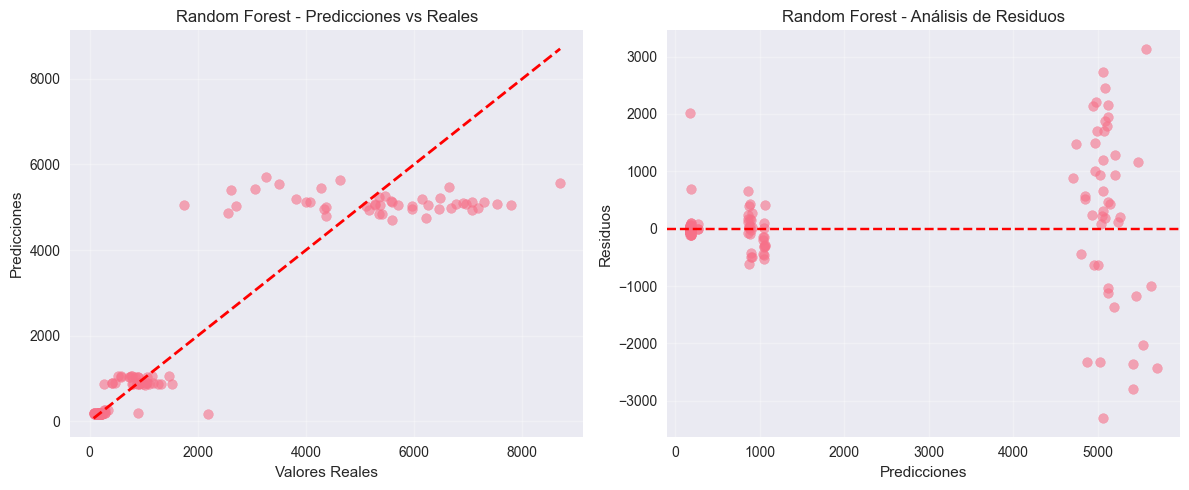

In [28]:
# Verificar y definir variables necesarias
if 'best_model_name' not in globals():
    best_model_name = results_sorted.index[0]

# Obtener predicciones del mejor modelo
if 'best_predictions' not in globals():
    if best_model_name == 'Random Forest':
        best_predictions = rf_pred
        best_model = rf
    elif best_model_name == 'Gradient Boosting':
        best_predictions = gb_pred
        best_model = gb
    elif best_model_name == 'Decision Tree':
        best_predictions = dt_pred
        best_model = dt
    elif best_model_name == 'Linear Regression':
        best_predictions = lr_pred
        best_model = lr
    elif best_model_name == 'Ridge':
        best_predictions = ridge_pred
        best_model = ridge
    elif best_model_name == 'Lasso':
        best_predictions = lasso_pred
        best_model = lasso
    else:  # ElasticNet
        best_predictions = elastic_pred
        best_model = elastic

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'{best_model_name} - Predicciones vs Reales')
plt.grid(True, alpha=0.3)

# Residuos
plt.subplot(1, 2, 2)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title(f'{best_model_name} - Análisis de Residuos')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Resumen y Conclusiones

In [29]:
print("=== RESUMEN FINAL ===")
print(f"Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Dataset para modelado: {X_clean.shape[0]} filas, {X_clean.shape[1]} variables predictoras")
print(f"División: {X_train.shape[0]} entrenamiento, {X_test.shape[0]} prueba")
print(f"\nMejor modelo: {best_model_name}")
print(f"R² de test: {results_sorted.loc[best_model_name, 'R2_test']:.4f}")
print(f"RMSE de test: {results_sorted.loc[best_model_name, 'RMSE_test']:.4f}")
print(f"MAE de test: {results_sorted.loc[best_model_name, 'MAE_test']:.4f}")

print("\n=== TOP 3 MODELOS ===")
for i, (model_name, metrics) in enumerate(results_sorted.head(3).iterrows()):
    print(f"{i+1}. {model_name}: R²={metrics['R2_test']:.4f}, RMSE={metrics['RMSE_test']:.4f}")

# Si el mejor modelo es Random Forest o Gradient Boosting, mostrar importancia de características
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print("\n=== IMPORTANCIA DE CARACTERÍSTICAS ===")
    if best_model_name == 'Random Forest':
        print(feature_importance.to_string(index=False))

=== RESUMEN FINAL ===
Dataset original: 460 filas, 9 columnas
Dataset para modelado: 456 filas, 5 variables predictoras
División: 319 entrenamiento, 137 prueba

Mejor modelo: Random Forest
R² de test: 0.8530
RMSE de test: 968.7818
MAE de test: 559.0940

=== TOP 3 MODELOS ===
1. Random Forest: R²=0.8530, RMSE=968.7818
2. Decision Tree: R²=0.8448, RMSE=995.3994
3. ElasticNet: R²=0.8408, RMSE=1008.2887

=== IMPORTANCIA DE CARACTERÍSTICAS ===
          feature  importance
          Area_m2    0.975060
           Sector    0.018119
           Ciudad    0.004466
          Estrato    0.001910
Puede_Pagar_Solar    0.000445
